In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import json
import os
from os import path as osp
import shutil

from PIL import Image, ImageDraw

from matplotlib.path import Path as mpath

In [24]:
def get_mask(nx, ny, poly_verts_list):
    '''
    polygons: List of polygons [   [(x1, y1), (x2, y2), ...], ...  ]
    
    Returns a mask comprising of 0s and 1s, s.t., space inside the polygon are 1s
    '''
    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    # Source: https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    grid_list = []
    for poly_verts in poly_verts_list:
        path = mpath(poly_verts)
        grid = path.contains_points(points)
        grid = grid.reshape((ny,nx))
        grid_list.append(grid)
    
    combined_grid = reduce(lambda x, y : x | y, grid_list)
    return combined_grid.astype(int)

In [ ]:
def computeIoU(gt_mask, pred_mask):
    '''
    Masks contain [-1, 0, 1]
    -1 indicates ignore regions
    '''

In [96]:
def computePrecRecAcc(gt_mask, pred_mask):
    '''
    Masks contain [-1, 0, 1]
    -1 indicates ignore regions
    '''
    assert(gt_mask.size == pred_mask.size)
    tp = float(np.sum(np.logical_and(pred_mask == 1, gt_mask == 1)))
    fp = float(np.sum(np.logical_and(pred_mask == 1, gt_mask == 0)))
    fn = float(np.sum(np.logical_and(pred_mask == 0, gt_mask == 1)))
    
    prec = tp / (tp + fp)
    rec  = tp / (tp + fn)
    iou  = tp / (tp + fn + fp)
    
    return prec, rec, iou

In [153]:
def convert_mask_to_img(mask, hot_color):
    assert len(hot_color) == 3
    
    # Create a canvas filled with hot_color
    h, w = mask.shape
    im = np.zeros((h, w, 3))
    im[:, :] = hot_color
    im[:, :] *= mask[:, :, None]
    return im

In [154]:
def visualize_errors(img_path, gt_mask, pred_mask, metrics_text=''):
    '''
    Masks contain [-1, 0, 1]
    -1 indicates ignore regions
    '''
    im = Image.open(image_path)
    w, h = im.size
    
    assert(gt_mask.size == pred_mask.size)
    tp = np.logical_and(pred_mask == 1, gt_mask == 1)
    fp = np.logical_and(pred_mask == 1, gt_mask == 0)
    tn = np.logical_and(pred_mask == 0, gt_mask == 0)
    fn = np.logical_and(pred_mask == 0, gt_mask == 1)
    
    # Actual Image
    plt.subplot(231)
    plt.axis('off')
    plt.imshow(im)
    plt.title('Image')
    
    # True Positives
    plt.subplot(232)
    plt.axis('off')
    plt.imshow(im, alpha=0.5)
    # plt.imshow(tp, alpha=0.8)
    plt.imshow(convert_mask_to_img(tp, [0, 1, 0]), alpha=0.8)
    plt.title('True Positives')
    
    # Text
    plt.subplot(233)
    plt.axis('off')
    dummy = np.zeros((9, 16))
    plt.imshow(dummy, alpha=0.0)
    plt.text(0, 4, metrics_text, family='monospace', fontsize='large', color='black')
    plt.title('Metrics')
    
    # False Negatives
    plt.subplot(234)
    plt.axis('off')
    plt.imshow(im, alpha=0.5)
    # plt.imshow(fn, alpha=0.8)
    plt.imshow(convert_mask_to_img(fn, [1, 0, 0]), alpha=0.8)
    plt.title('False Negatives')
    
    # False Positives
    plt.subplot(235)
    plt.axis('off')
    plt.imshow(im, alpha=0.5)
    # plt.imshow(fp, alpha=0.8)
    plt.imshow(convert_mask_to_img(fp, [1, 1, 0]), alpha=0.8)
    plt.title('False Positives')
    
    # Text
    plt.subplot(236)
    plt.axis('off')
    dummy = np.zeros((9, 16))
    plt.imshow(dummy, alpha=0.0)
    
    plt.tight_layout()
    plt.show()

## Test

In [7]:
annotation_file_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/annotations/tribhu_40m.json'
image_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/images_30/2017_19010723.jpg'

# Obtain annotation for this image

_, img_filename = osp.split(image_path)
anno_dct = dict()   # load annotation for this file here

with open(annotation_file_path) as jf:
    dct = json.load(jf)
    
    # This is a represented as <filename><size>
    for k, v in dct.iteritems():
        if v['filename'] == img_filename:
            anno_dct = v
            break

In [25]:
im = Image.open(image_path)
w, h = im.size

poly_verts_list = []

for idx, (region_id, region_dct) in enumerate(anno_dct['regions'].iteritems()):
    poly_verts = zip(region_dct['shape_attributes']['all_points_x'], region_dct['shape_attributes']['all_points_y'])
    poly_verts_list.append(poly_verts)

mask = get_mask(w, h, poly_verts_list)

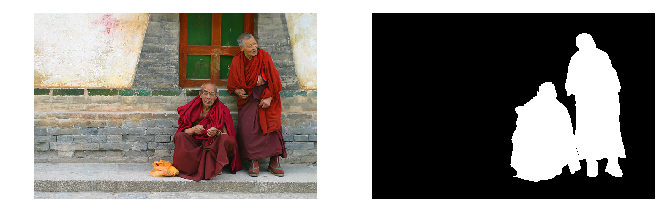

In [27]:
plt.subplot(121)
plt.axis('off')
plt.imshow(im)
plt.subplot(122)
plt.axis('off')
plt.imshow(mask)
plt.show()

## Test - Visualizing errors

In [30]:
def load_anno(image_path, anno_path):
    # Obtain annotation for this image
    _, img_filename = osp.split(image_path)
    anno_dct = dict()   # load annotation for this file here

    with open(anno_path) as jf:
        dct = json.load(jf)

        # This is a represented as <filename><size>
        for k, v in dct.iteritems():
            if v['filename'] == img_filename:
                anno_dct = v
                break
    return anno_dct

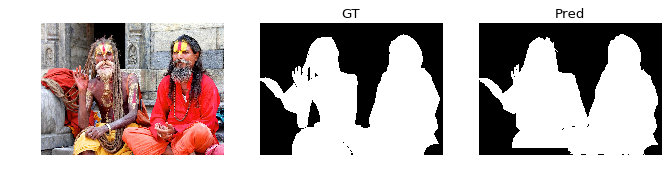

In [42]:
gt_annotation_file_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/annotations/tribhu_40m.json'
pred_annotation_file_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/annotations/nana.json'
image_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/images_30/2017_37742237.jpg'

gt_anno = load_anno(image_path, gt_annotation_file_path)
pred_anno = load_anno(image_path, pred_annotation_file_path)

im = Image.open(image_path)
w, h = im.size

# GT Mask
poly_verts_list = []
for idx, (region_id, region_dct) in enumerate(gt_anno['regions'].iteritems()):
    poly_verts = zip(region_dct['shape_attributes']['all_points_x'], region_dct['shape_attributes']['all_points_y'])
    poly_verts_list.append(poly_verts)

gt_mask = get_mask(w, h, poly_verts_list)

# Pred Mask
poly_verts_list = []
for idx, (region_id, region_dct) in enumerate(pred_anno['regions'].iteritems()):
    poly_verts = zip(region_dct['shape_attributes']['all_points_x'], region_dct['shape_attributes']['all_points_y'])
    poly_verts_list.append(poly_verts)

pred_mask = get_mask(w, h, poly_verts_list)

plt.subplot(131)
plt.axis('off')
plt.imshow(im)
plt.subplot(132)
plt.axis('off')
plt.imshow(gt_mask)
plt.title('GT')
plt.subplot(133)
plt.axis('off')
plt.imshow(pred_mask)
plt.title('Pred')

plt.show()

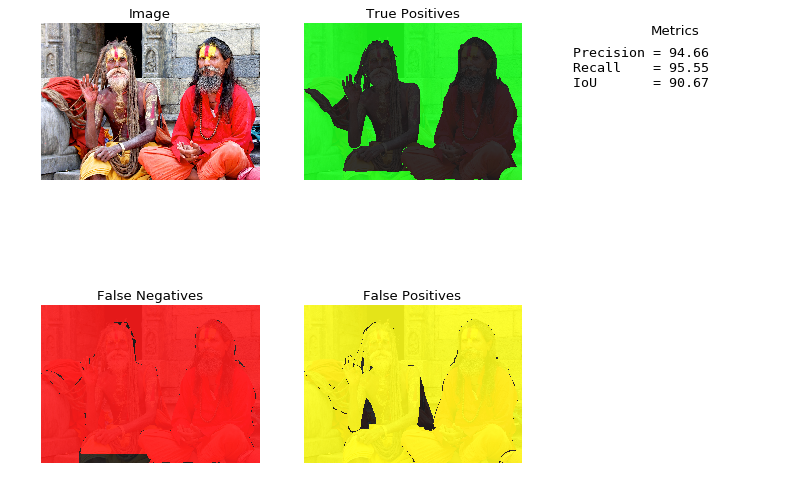

In [152]:
p, r, iou = computePrecRecAcc(gt_mask, pred_mask)
metrics_text  = 'Precision = {:.2f}\n'.format(100 * p)
metrics_text += 'Recall    = {:.2f}\n'.format(100 * r)
metrics_text += 'IoU       = {:.2f}\n'.format(100 * iou)
visualize_errors(image_path, gt_mask, pred_mask, metrics_text)